# Import libraries

In [28]:

import datetime as dt
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import h2o
import sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from shapely.geometry import Polygon
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from statsmodels.tools.tools import add_constant

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML
from tpot import TPOTClassifier
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import sys
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score,rand_score,fowlkes_mallows_score
from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering,MeanShift
import pickle


# Load the cleaned and preprocessed data

In [3]:
accidents_sub = pd.read_csv("C:\\Users\\reza3\\OneDrive\\Desktop\\AIT\\Machine learning\\group project\\data\\sub_accidents.csv")
accidents_sub = accidents_sub[accidents_sub["Start_Year"]>2020]

In [5]:
accidents_sub.shape

(3047692, 38)

# create train and test data

In [6]:
X = accidents_sub.drop(columns=['Unnamed: 0', 'ID', 'Severity', 'Delay(min)', 'Street', 'City', 'County', 'State', 'Zipcode',
       'Start_Year', 'Start_Month', 'Start_Day', 
       'Start_time','Distance(km)', 'Delay_ln', 'Severity_new'])
Y = accidents_sub.loc[:, ['Severity', 'Severity_new', 'Delay(min)', 'Delay_ln', 'Distance(km)']]


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y["Severity_new"], test_size = 0.10, random_state=370, stratify=Y["Severity_new"])

assert len(X_train)  == len(Y_train)
assert len(X_test)   == len(Y_test)
X.shape, Y.shape,X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3047692, 22),
 (3047692, 5),
 (2742922, 22),
 (304770, 22),
 (2742922,),
 (304770,))

# Fixing imbalance classes

In [50]:
# Imbalance classes of the label is severe, so first I created a new feature named severity_new and the tried different methods to deal with imbalance
accidents_sub["Severity_new"].value_counts(sort=False)

Severity_new
0    2775400
1     272292
Name: count, dtype: int64

In [ ]:
'''# fixing imbalance by under sampling (Tomek links) (it didn't help)
tl = TomekLinks(n_jobs=-1, sampling_strategy="Majority")

# fit predictor and target variable
X_train_tl, Y_train_tl = tl.fit_resample(X_train, Y_train["Severity_new"])'''

In [8]:
# fixing imbalance by under sampling (random under sampling without replacement)
rus = RandomUnderSampler(random_state=370, replacement=False)

# fit predictor and target varialbe
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

X.shape, Y.shape, X_train_rus.shape, Y_train_rus.shape

((3047692, 22), (3047692, 5), (490126, 22), (490126,))

# Regression Model
I tried to fit a regression model with Delay and distance as labels but no appropriate model have found. 

In [ ]:
'''model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=370)

model.fit(X_train, Y_train["Distance(km)"])

# Make predictions on the validation set
y_train_pred = model.predict(X_train)

# Calculate metrics
mse = mean_squared_error(Y_train["Distance(km)"], y_train_pred)
r2 = r2_score(Y_train["Distance(km)"], y_train_pred)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R_squared on Test Set: {r2}')'''




# Classification models

In [22]:
lr = LogisticRegression(random_state=370, n_jobs=-1)
rf = RandomForestClassifier(random_state=370, n_jobs=-1, oob_score=True)
sgb = xgboost.XGBClassifier(max_depth=1, n_estimators=200, n_jobs=-1)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.001, random_state=370)

models = [ lr, rf, sgb, ada]

#perform cross validation using KFold
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits = 5, shuffle = True, random_state=370)

for model in models:
    score = cross_val_score(model, X_train_rus, Y_train_rus, cv=kfold, scoring='accuracy', n_jobs=-1)  #f1, recall, precision, accuracy
    np.set_printoptions(precision = 2)
    print("Model: ", model, "Scores: ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better):", score.std()) 
    fit = model.fit(X_train_rus, Y_train_rus)
    yhat = fit.predict(X_test)
    print(confusion_matrix(Y_test, yhat).ravel())
    print('ROCAUC score:',roc_auc_score(Y_test, yhat))      
    print(classification_report(Y_test, yhat))

Model:  LogisticRegression(n_jobs=-1, random_state=370) Scores:  [0.57 0.57 0.57 0.57 0.57] - Scores mean:  0.5707777215891273 - Scores std (lower better): 0.0016765492161903536
[125476 152065   8439  18790]
ROCAUC score: 0.5710860265028719
              precision    recall  f1-score   support

           0       0.94      0.45      0.61    277541
           1       0.11      0.69      0.19     27229

    accuracy                           0.47    304770
   macro avg       0.52      0.57      0.40    304770
weighted avg       0.86      0.47      0.57    304770

Model:  RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=370) Scores:  [0.62 0.62 0.62 0.62 0.63] - Scores mean:  0.6241578733076416 - Scores std (lower better): 0.0012007246685853084
[171228 106313   9713  17516]
ROCAUC score: 0.6301157092717378
              precision    recall  f1-score   support

           0       0.95      0.62      0.75    277541
           1       0.14      0.64      0.23     27229

    acc

In [25]:
param_grid = {"n_estimators": [100, 200, 300], "criterion": ["gini", "entropy"], "max_depth": np.arange(1, 10)}
model = RandomForestClassifier(n_jobs=-1, random_state=370, oob_score=True)
grid = GridSearchCV(model, param_grid, refit=True, n_jobs=-1)
grid.fit(X_train_rus, Y_train_rus)
print(grid.best_params_)
yhat = grid.predict(X_test)
print(classification_report(Y_test, yhat))

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.94      0.57      0.71    277541
           1       0.13      0.64      0.21     27229

    accuracy                           0.58    304770
   macro avg       0.53      0.61      0.46    304770
weighted avg       0.87      0.58      0.66    304770



# The final model

In [43]:
model_final = RandomForestClassifier(n_estimators= 200, criterion="gini", max_depth= 9, n_jobs=-1, random_state=370)
model_final.fit(X_train_rus, Y_train_rus)
yhat = model_final.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
print("True Negative = ",tn, " False Negative = ",fn, "True Positive = ", tp, "False Positive = ", fn)
print(classification_report(Y_test, yhat))

True Negative =  159944  False Negative =  6840 True Positive =  20389 False Positive =  6840
              precision    recall  f1-score   support

           0       0.96      0.58      0.72    277541
           1       0.15      0.75      0.25     27229

    accuracy                           0.59    304770
   macro avg       0.55      0.66      0.48    304770
weighted avg       0.89      0.59      0.68    304770



# Analyse (Features importance)

In [81]:
id = range(1,23)
id.reshape(1,-1).shape
#feature_imp.reshape(-1,1).shape

AttributeError: 'range' object has no attribute 'reshape'

<Axes: >

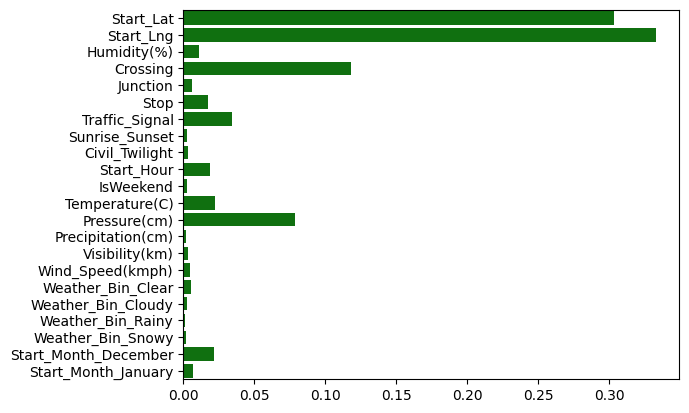

In [112]:
feature_imp = model_final.feature_importances_
feature_names = model_final.feature_names_in_
feature_importance = [feature_names, feature_imp]
feature_importance[0]
sns.barplot( y= feature_importance[0], x=feature_importance[1], color="green")


# Save the model and inference

In [44]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model_final, file)



In [45]:
# Load the model back using pickle
with open('random_forest_model.pkl', 'rb') as file:
    loaded_rf_model = pickle.load(file)

In [46]:
new_data = X_test.iloc[[0]]  # Your new data here

# Use the loaded model for prediction
predictions = loaded_rf_model.predict(new_data)
print("Predictions:", predictions)

Predictions: [0]


In [61]:
feature_importance

,Feature_Importance
0,
Start_Lng,0.332718
Start_Lat,0.303462
Crossing,0.117945
Pressure(cm),0.078728
Traffic_Signal,0.034036
Temperature(C),0.022583
Start_Month_December,0.021364
Start_Hour,0.018908
Stop,0.017270


In [29]:
print(model.feature_names_in_)

['Start_Lat' 'Start_Lng' 'Humidity(%)' 'Crossing' 'Junction' 'Stop'
 'Traffic_Signal' 'Sunrise_Sunset' 'Civil_Twilight' 'Start_Hour'
 'IsWeekend' 'Temperature(C)' 'Pressure(cm)' 'Precipitation(cm)'
 'Visibility(km)' 'Wind_Speed(kmph)' 'Weather_Bin_Clear'
 'Weather_Bin_Cloudy' 'Weather_Bin_Rainy' 'Weather_Bin_Snowy'
 'Start_Month_December' 'Start_Month_January']


In [30]:
#fitting model with class weights parameter to fix imbalance
model = RandomForestClassifier(n_estimators= 200, criterion="gini", max_depth= 9, n_jobs=-1, random_state=370, class_weight="balanced_subsample")
model.fit(X_train, Y_train)
yhat = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
print("True Negative = ",tn, " False Negative = ",fn, "True Positive = ", tp, "False Positive = ", fn)
print(classification_report(Y_test, yhat))

True Negative =  159513  False Negative =  9900 True Positive =  17329 False Positive =  9900
              precision    recall  f1-score   support

           0       0.94      0.57      0.71    277541
           1       0.13      0.64      0.21     27229

    accuracy                           0.58    304770
   macro avg       0.53      0.61      0.46    304770
weighted avg       0.87      0.58      0.67    304770



In [31]:
model = RandomForestClassifier(n_estimators= 200, criterion="gini", max_depth= 9, n_jobs=-1, random_state=370, class_weight="balanced")
model.fit(X_train, Y_train)
yhat = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
print("True Negative = ",tn, " False Negative = ",fn, "True Positive = ", tp, "False Positive = ", fn)
print(classification_report(Y_test, yhat))

True Negative =  159312  False Negative =  9888 True Positive =  17341 False Positive =  9888
              precision    recall  f1-score   support

           0       0.94      0.57      0.71    277541
           1       0.13      0.64      0.21     27229

    accuracy                           0.58    304770
   macro avg       0.53      0.61      0.46    304770
weighted avg       0.87      0.58      0.67    304770



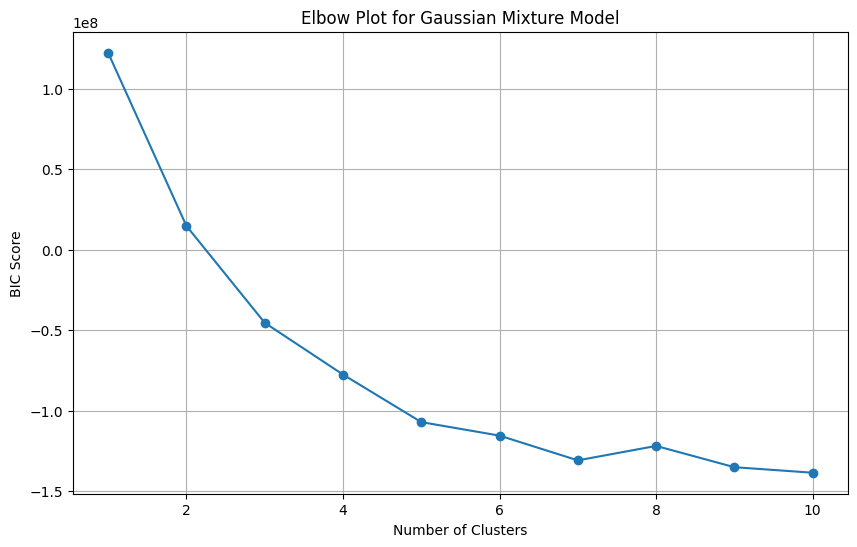

Optimal Number of Clusters: 10
Log-Likelihood on Test Data: 25.242203179775913
Silhouette Score on Test Data: -0.10340246720045451


In [63]:
# Range of clusters to test
n_clusters_range = range(1, 11)
bic_scores = []

# Fit the model for each number of clusters and compute BIC
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_for_cluster)
    
    # BIC (Bayesian Information Criterion) score
    bic_scores.append(gmm.bic(X_for_cluster))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, bic_scores, marker='o')
plt.title('Elbow Plot for Gaussian Mixture Model')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()
'''
# Choose the optimal number of clusters based on the elbow plot
optimal_n_clusters = np.argmin(bic_scores) + 1  # +1 because Python is zero-indexed
print(f'Optimal Number of Clusters: {optimal_n_clusters}')

# Train the model with the optimal number of clusters
optimal_gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
optimal_gmm.fit(X_train)

# Predict the clusters for the testing data
test_labels = optimal_gmm.predict(X_test)

# Evaluate the model on the testing data
test_score = optimal_gmm.score(X_test)
silhouette_score = metrics.silhouette_score(X_test, test_labels)

print(f'Log-Likelihood on Test Data: {test_score}')
print(f'Silhouette Score on Test Data: {silhouette_score}')'''


In [36]:
gmm = GaussianMixture(n_components=5, init_params="random_from_data", random_state=370)
gmm.fit(X_for_cluster)
cluster = gmm.predict(X_for_cluster).astype(int)





In [78]:
silhouette_score(X_for_cluster, gmm.fit_predict(X_for_cluster))

: 

In [ ]:
X_with_clusters = pd.merge(pd.DataFrame(X_for_cluster), pd.DataFrame({'Cluster': cluster}), left_index=True, right_index=False)


In [64]:
cluster.shape, X_for_cluster.shape, X_with_clusters.shape

((3047692,), (3047692, 26), (2608314, 27))

<Axes: xlabel='Start_Lat', ylabel='Start_Lng'>

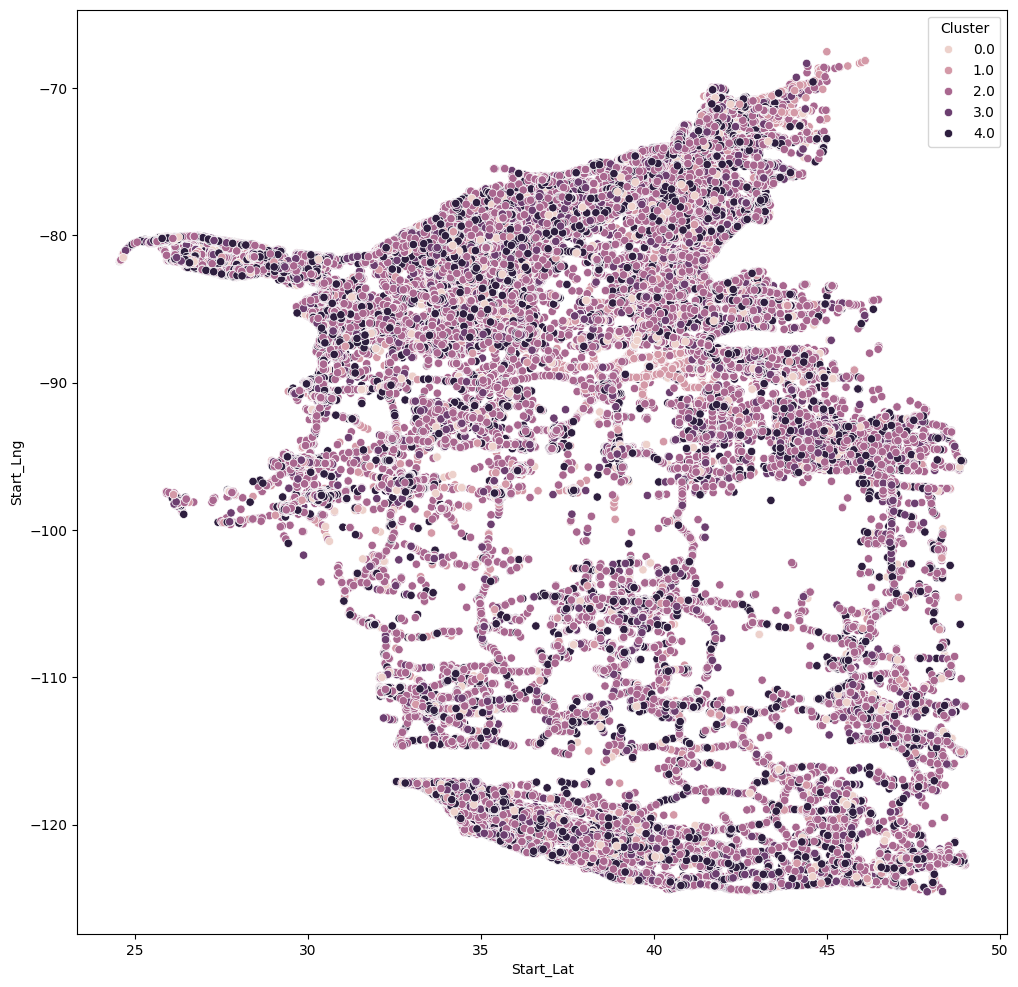

In [26]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=X_with_clusters["Start_Lat"], y = X_with_clusters["Start_Lng"], hue = X_with_clusters["Cluster"])

In [27]:
import folium
from folium.plugins import MarkerCluster

# Assuming X_train_with_clusters is your training data with added cluster labels
# Assuming X_test_with_clusters is your testing data with added cluster labels

# Create a map centered at the mean of the latitude and longitude in your data
mean_lat = X_with_clusters['Start_Lat'].mean()
mean_lon = X_with_clusters['Start_Lng'].mean()

map_clusters = folium.Map(location=[mean_lat, mean_lon], zoom_start=10)

# Create a MarkerCluster layer for the training data
marker_cluster_train = MarkerCluster().add_to(map_clusters)

# Add markers for each point in the training data with cluster information
for index, row in X_with_clusters.iterrows():
    folium.Marker(location=[row['Start_Lat'], row['Start_Lng']],
                  popup=f'Cluster: {row["Cluster"]}',
                  icon=None).add_to(marker_cluster_train)

# Create a MarkerCluster layer for the testing data
marker_cluster_test = MarkerCluster().add_to(map_clusters)

# Add markers for each point in the testing data with cluster information
for index, row in X_with_clusters.iterrows():
    folium.Marker(location=[row['Start_Lat'], row['Start_Lng']],
                  popup=f'Cluster: {row["Cluster"]}',
                  icon=None).add_to(marker_cluster_test)

# Save or display the map
map_clusters.save("cluster_map.html")
map_clusters


ValueError: Location values cannot contain NaNs.

In [35]:
X_for_cluster.isna().sum()

Unnamed: 0              0
Severity                0
Delay(min)              0
Start_Lat               0
Start_Lng               0
Humidity(%)             0
Crossing                0
Junction                0
Stop                    0
Traffic_Signal          0
Sunrise_Sunset          0
Civil_Twilight          0
Start_Hour              0
IsWeekend               0
Temperature(C)          0
Pressure(cm)            0
Precipitation(cm)       0
Distance(km)            0
Visibility(km)          0
Wind_Speed(kmph)        0
Weather_Bin_Clear       0
Weather_Bin_Cloudy      0
Weather_Bin_Rainy       0
Weather_Bin_Snowy       0
Start_Month_December    0
Start_Month_January     0
dtype: int64

In [17]:
X_with_clusters.head()

,Unnamed: 0,Severity,Delay(min),Start_Lat,Start_Lng,Humidity(%),Crossing,Junction,Stop,Traffic_Signal,...,Distance(km),Visibility(km),Wind_Speed(kmph),Weather_Bin_Clear,Weather_Bin_Cloudy,Weather_Bin_Rainy,Weather_Bin_Snowy,Start_Month_December,Start_Month_January,Cluster
0,512217.0,1.0,45.383333,41.946796,-88.208092,90.0,0.0,0.0,0.0,1.0,...,0.000000,16.09340,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,512218.0,1.0,149.450000,34.521172,-117.958076,28.0,0.0,0.0,0.0,0.0,...,0.000000,16.09340,9.65604,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,512219.0,1.0,144.083333,37.542839,-77.441780,96.0,1.0,0.0,0.0,1.0,...,0.000000,16.09340,12.87472,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,512220.0,1.0,29.750000,40.896629,-81.178452,86.0,0.0,0.0,0.0,0.0,...,0.000000,11.26538,9.65604,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,512221.0,2.0,29.633333,41.409359,-81.644318,87.0,0.0,0.0,0.0,0.0,...,3.073839,11.26538,4.82802,0.0,1.0,0.0,0.0,0.0,0.0,5.0


In [20]:
X_with_clusters["Cluster"].value_counts(sort=False)

Cluster
1.0     198088
5.0    1669321
8.0     103090
6.0     480080
9.0      77905
3.0      26357
7.0     192620
2.0      55133
0.0     229298
4.0      15800
Name: count, dtype: int64